In [1]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score,mean_absolute_error,classification_report
from keras import Model
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers, models
from skimage import color
from skimage import filters
import tensorflow as tf
from tensorflow.keras.regularizers import L1L2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, LeakyReLU

### Get filter function that outputs the sobel filter from an image

### Choose the label type

In [3]:
# Choose the label type
Labeltype = 'age'
samplesize = 5000
replacev = False
Nlabels = -1
if(Labeltype == 'age'):
    Nlabels = 9
if(Labeltype == 'gender'):
    Nlabels = 2
if(Labeltype == 'race'):
    Nlabels = 5

### Get the file paths and labels
### Split into train-test-validate
### Balance the train paths and labels

In [4]:
# Import image labels and paths to dataframe
mypath = "../data/raw/CroppedImages/"
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns).astype({'age': 'int', 'gender': 'int', 'race': 'int'})

# Convert age to appropriate labels
filedf['age']=np.where((filedf.age<3), 0, filedf.age)
filedf['age']=np.where(((filedf.age>=3) & (filedf.age<6)), 1, filedf.age)
filedf['age']=np.where(((filedf.age>=6) & (filedf.age<9)), 2, filedf.age)
filedf['age']=np.where(((filedf.age>=9) & (filedf.age<12)), 3, filedf.age)
filedf['age']=np.where(((filedf.age>=12) & (filedf.age<21)), 4, filedf.age)
filedf['age']=np.where(((filedf.age>=21) & (filedf.age<36)), 5, filedf.age)
filedf['age']=np.where(((filedf.age>=36) & (filedf.age<51)), 6, filedf.age)
filedf['age']=np.where(((filedf.age>=51) & (filedf.age<80)), 7, filedf.age)
filedf['age']=np.where((filedf.age>=80), 8, filedf.age)

dfx = filedf.loc[:,'file']
dfy = filedf.loc[:,Labeltype]

# Get Train/Test
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)

# Get Train/Test/Validation dataset 0.25 * 8 = 0.2
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Encode training labels and initialize random over sampler
yencoded = LabelEncoder().fit_transform(y_train_2)
oversample = RandomOverSampler()

# Over sample until training classes are balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(np.array(X_train_2).reshape(-1,1), yencoded)

# Of all classes, proportionally sample 10000
dxy = {'file': X_train_balanced.reshape(len(X_train_balanced)), 'label': y_train_balanced}
dfbalanced = pd.DataFrame(data = dxy)
balancedsamples = int(samplesize/len(set(dfbalanced.loc[:,'label'])))
dfbalancedsubset = dfbalanced.groupby('label', group_keys=False).apply(lambda x: x.sample(balancedsamples, replace = replacev)).sample(frac=1)

# Count and print prebalanced classes
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes
counter = Counter(y_train_balanced)
for k,v in counter.items():
    per = v / len(y_train_balanced) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes subsets (Total should be 10000)
counter = Counter(dfbalancedsubset.loc[:,'label'])
for k,v in counter.items():
    per = v / len(dfbalancedsubset.loc[:,'label']) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=7, n=3134 (16.526%)
Class=5, n=8166 (43.061%)
Class=3, n=323 (1.703%)
Class=8, n=541 (2.853%)
Class=0, n=1277 (6.734%)
Class=2, n=426 (2.246%)
Class=4, n=1290 (6.802%)
Class=6, n=3199 (16.869%)
Class=1, n=608 (3.206%)
Class=5, n=6093 (11.111%)
Class=2, n=6093 (11.111%)
Class=6, n=6093 (11.111%)
Class=0, n=6093 (11.111%)
Class=8, n=6093 (11.111%)
Class=7, n=6093 (11.111%)
Class=3, n=6093 (11.111%)
Class=4, n=6093 (11.111%)
Class=1, n=6093 (11.111%)
Class=6, n=555 (11.111%)
Class=3, n=555 (11.111%)
Class=8, n=555 (11.111%)
Class=2, n=555 (11.111%)
Class=5, n=555 (11.111%)
Class=1, n=555 (11.111%)
Class=7, n=555 (11.111%)
Class=4, n=555 (11.111%)
Class=0, n=555 (11.111%)


### Function to get images

In [5]:
def get_images(filelist,rgb = True):
    dims = 0
    if(rgb):
        dims=3
    else:
        dims=1
    container = np.zeros((len(filelist),200,200,dims))
    for index,i in enumerate(filelist):
        img = cv2.imread(i)
        if(not rgb):
            img = color.rgb2gray(img)
        container[index,:,:,:dims]=img
    return container

### Create and run balanced dataset

In [6]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)

### Clear variables if necessary

In [7]:
del train_img_container
del validation_img_container
del test_img_container
del CNNmodel

### Arrays for tracking the history of attempts

In [34]:
valacc = []
valloss = []
l1arr = []
l2arr = []
droparr = []

In [8]:
l1reg = 0
l2reg = 0
dropoutn = 0
patience = 5

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience = patience,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)
for l1 in [0.0]:
    for l2 in [0.0]:
        for do in [0.8]:
            print(str(l1) + ',' + str(l2) + ',' + str(do))
            if 'CNNmodel' in globals():
                del CNNmodel
            CNNmodel = models.Sequential()
            CNNmodel.add(layers.Conv2D(32, (3, 3), 
                                       activation=LeakyReLU(), 
                                       input_shape=train_img_container[0].shape, 
                                       kernel_regularizer = L1L2(l1=l1, l2=l2)))
            CNNmodel.add(layers.MaxPooling2D((2, 2)))
            CNNmodel.add(layers.Conv2D(64, (3, 3), activation=LeakyReLU(),kernel_regularizer = L1L2(l1=l1, l2=l2)))
            CNNmodel.add(layers.MaxPooling2D((2, 2)))
            CNNmodel.add(layers.Conv2D(128, (3, 3), activation=LeakyReLU(),kernel_regularizer = L1L2(l1=l1, l2=l2)))
            CNNmodel.add(layers.Flatten())
            CNNmodel.add(layers.Dense(64, activation=LeakyReLU()))
            CNNmodel.add(Dropout(do))
            CNNmodel.add(layers.Dense(Nlabels, activation='softmax'))
            CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])                
            # Validation training and testing
            val_history = CNNmodel.fit(train_img_container
                                       ,np.array(dfbalancedsubset.loc[:,'label'])
                                       , epochs=20
                                       , validation_data=(validation_img_container, y_val)
                                       ,callbacks=[callback]
                                       )
            ypredval = CNNmodel.predict(validation_img_container)
            best_index = np.argmax(val_history.history['val_accuracy'])
            valacc.append(val_history.history['val_accuracy'][best_index])
            valloss.append(val_history.history['val_loss'][best_index])
            l1arr.append(l1)
            l2arr.append(l2)
            droparr.append(do)

0.0,0.0,0.8
Epoch 1/20
157/157 [==============================] - 167s 1s/step - loss: 211.6803 - accuracy: 0.1884 - val_loss: 20.6141 - val_accuracy: 0.2936
Epoch 2/20
157/157 [==============================] - 150s 953ms/step - loss: 24.0438 - accuracy: 0.3063 - val_loss: 8.1699 - val_accuracy: 0.3691
Epoch 3/20
106/157 [===================>..........] - ETA: 41s - loss: 14.0875 - accuracy: 0.3700

In [21]:
valloss.append(6.5782)

In [31]:
ValData = pd.DataFrame(data = [valacc,
valloss,
l1arr,
l2arr,
droparr]).transpose().rename(columns = {0:'acc', 1:'loss',2:'l1',3:'l2',4:'drop'})

In [32]:
ValData.head()

,acc,loss,l1,l2,drop
0,0.485552,3.907209,0.0,0.0,0.0
1,0.464248,7.120487,0.0,0.0,0.2
2,0.465092,5.827605,0.0,0.0,0.4
3,0.465900,6.578200,0.0,0.0,0.6


In [33]:
ValData.to_csv('FirstData.csv',index = False)

In [23]:
best_index = np.argmax(val_history.history['val_accuracy'])
valacc.append(val_history.history['val_accuracy'][best_index])
valloss.append(val_history.history['val_loss'][best_index])

0.12402446568012238

In [12]:
ypredval = CNNmodel.predict(validation_img_container)
ypredtest = CNNmodel.predict(test_img_container)

149/149 [==============================] - 24s 159ms/step


In [13]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       308
           1       0.43      0.52      0.47       157
           2       0.32      0.35      0.33        95
           3       0.23      0.17      0.20        92
           4       0.27      0.39      0.32       336
           5       0.73      0.65      0.69      2073
           6       0.37      0.37      0.37       806
           7       0.54      0.54      0.54       729
           8       0.43      0.51      0.46       145

    accuracy                           0.56      4741
   macro avg       0.45      0.48      0.47      4741
weighted avg       0.57      0.56      0.56      4741



In [14]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       328
           1       0.39      0.50      0.44       150
           2       0.28      0.29      0.29       107
           3       0.22      0.27      0.24        64
           4       0.24      0.39      0.30       304
           5       0.72      0.64      0.67      2064
           6       0.36      0.35      0.36       793
           7       0.58      0.56      0.57       799
           8       0.41      0.58      0.48       132

    accuracy                           0.55      4741
   macro avg       0.45      0.49      0.46      4741
weighted avg       0.58      0.55      0.56      4741



In [ ]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

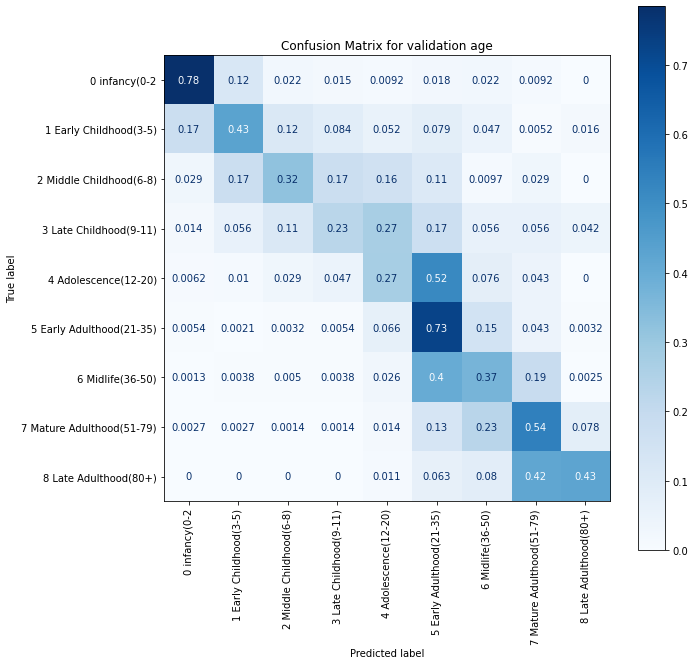

In [15]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

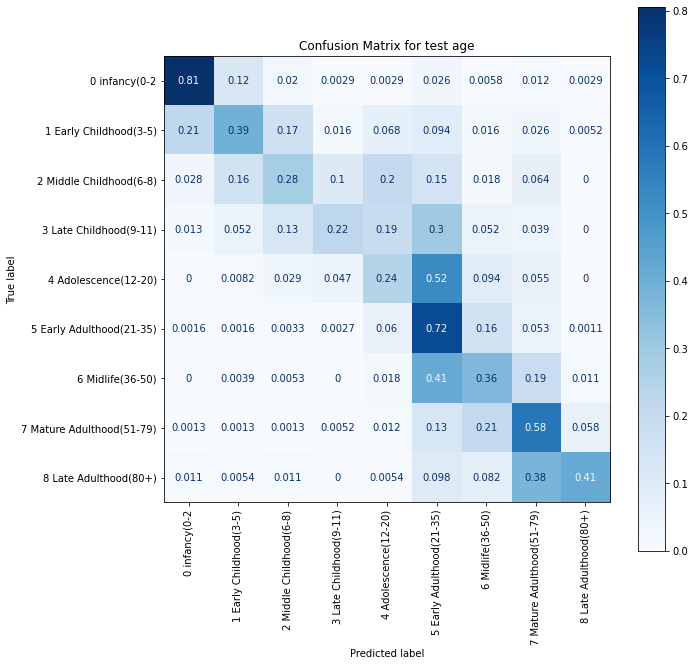

In [16]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set)
plt.xticks(rotation = 90)

plt.show()

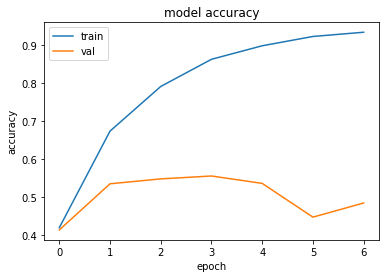

In [17]:
plt.plot(val_history.history['accuracy'])
plt.plot(val_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

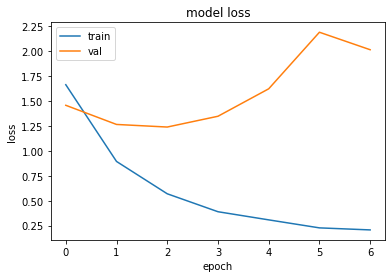

In [18]:
plt.plot(val_history.history['loss'])
plt.plot(val_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
ypredictions = CNNmodel.predict(test_img_container)

149/149 [==============================] - 25s 168ms/step


In [20]:
y_test_hot = y_test
y_test_hot_conv = np.zeros((y_test_hot.size, y_test_hot.max()+1))
y_test_hot_conv[np.arange(a.size),a] = 1

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [25]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Nlabels):
    fpr[i], tpr[i], _ = roc_curve(y_test_hot_conv[:, i], ypredictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(b.ravel(), ypredictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

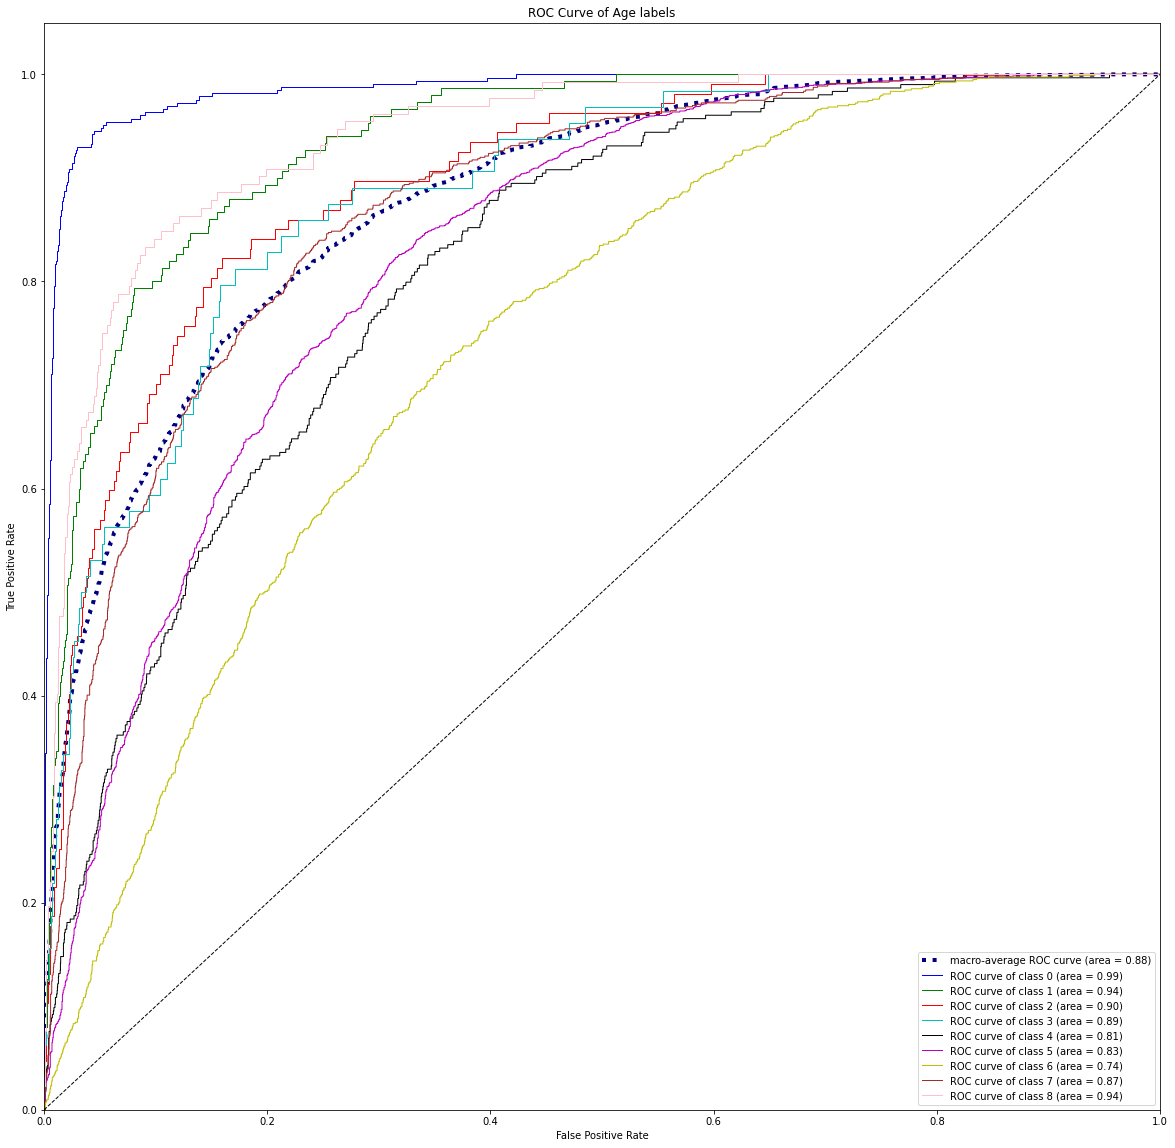

In [26]:

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(Nlabels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(Nlabels):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= Nlabels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,20))
lw = 1

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(['b','g','r','c','k','m','y','brown','pink'])
for i, color in zip(range(Nlabels), colors[:Nlabels]):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of Age labels")
plt.legend(loc="lower right")
plt.show()

In [10]:
model = tf.keras.models.load_model('CNNmodelgrey10000.h5')

In [27]:
CNNmodel.save('CNNmodelgreysobel10000dp04.h5')